In [1]:
import pandas as pd
import requests


In [2]:
url = "https://api.pbpstats.com/get-totals/nba"
params = {
    "Season": "2022-23",
    "SeasonType": "Regular Season",
    "Type": "Player"
}
response = requests.get(url, params=params)
response_json = response.json()
player_stats = response_json["multi_row_table_data"]
df = pd.DataFrame(player_stats)
col = ['Name','Minutes','Points','FG2M', 'FG2A', 'FG3M', 'FG3A', 'TsPct','AssistPoints','AtRimAssists','ShortMidRangeAssists', 'LongMidRangeAssists','Corner3Assists','Arc3Assists','LostBallSteals', 'LiveBallTurnovers', 'BadPassOutOfBoundsTurnovers', 'BadPassTurnovers',
       'DeadBallTurnovers', 'LostBallOutOfBoundsTurnovers', 'LostBallTurnovers', 'StepOutOfBoundsTurnovers', 'Travels', 'Turnovers','OffensiveGoaltends','FTA','OffPoss',
 'DefPoss','TotalPoss']
df[col].to_csv('wowy/player_small.csv',index = False)
df.to_csv('wowy/player_large.csv',index = False)

In [3]:

def get_sheets(season):
    frames = []
    for i in range(2000,2023):
        url = "https://api.pbpstats.com/get-totals/nba"
        params = {
            "Season": str(i) +"-" +str(i+1)[2:],
            "SeasonType":season,
            "Type": "Team"
        }
        response = requests.get(url, params=params)
        response_json = response.json()
        #print(response_json)
        team_stats = response_json["multi_row_table_data"]
        df = pd.DataFrame(team_stats)
        #print(df.head(1))
        df['year'] = i +1
        frames.append(df)
    return frames

In [4]:
#rframes = get_sheets('Regular Season')
#pframes = get_sheets('Playoffs')


In [5]:
#pdf = pd.concat(pframes)
#rdf = pd.concat(rframes)

In [6]:
#pdf.to_csv('pbp/team_playoff.csv',index = False)
#rdf.to_csv('pbp/team_regular.csv',index = False)


In [89]:
rdf = pd.read_csv('pbp/team_regular.csv')
pdf = pd.read_csv('pbp/team_playoff.csv')
rdf['ortg'] = (100*rdf['Points']/rdf['OffPoss']).round(2)
rdf['drtg'] = (100*rdf['OpponentPoints']/rdf['DefPoss']).round(2)

pdf['ortg'] = (100*pdf['Points']/pdf['OffPoss']).round(2)
pdf['drtg'] = (100*pdf['OpponentPoints']/pdf['DefPoss']).round(2)
col = [ 'SecondsPerPossOff',
 'SecondsPerPossDef',
 'SecondsExcludingORebsPerPossOff',
 'SecondsExcludingORebsPerPossDef',
      'ortg',
      'drtg',
       'Pace',
      'Name',
       'year'
      ]
pdf = pdf[col]

rdf = rdf[col]

df = rdf.merge(pdf, on =['Name','year'],suffixes=('_r', '_p'),how = 'left')
#ofspeed = 'SecondsExcludingORebsPerPossOff'
#dfspeed = 'SecondsExcludingORebsPerPossDef'
ofspeed= 'SecondsPerPossOff'
dfspeed ='SecondsPerPossDef'

In [90]:
rdf['Pace']

0       91.522343
1       95.014858
2       89.975855
3       90.066734
4       92.232558
          ...    
681     98.931488
682     98.110331
683     95.096234
684     99.684682
685    100.467277
Name: Pace, Length: 686, dtype: float64

In [91]:
df = df.dropna(subset ='drtg_p')

In [92]:
df['speed_change'] =df[ofspeed+'_p'] - df[ofspeed+'_r'] 
df['def_speed_change'] =df[dfspeed+'_p'] - df[dfspeed+'_r'] 
#change in speed between regular season and postseason
df['ortg_change'] = df['ortg_r'] - df['ortg_p']
df['drtg_change'] = df['drtg_r'] - df['drtg_p']
df['pace_change'] = df['Pace_r'] - df['Pace_p']
#change in ortg between regular & post seasons

In [93]:
df[['pace_change','year']]

,pace_change,year
2,0.725855,2001
3,4.066734,2001
5,3.867441,2001
9,4.884007,2001
15,-0.593474,2001
...,...,...
646,6.723342,2022
648,-1.881450,2022
650,2.661035,2022
652,-2.185162,2022


In [94]:
print(df['ortg_r'].corr(df[ofspeed+'_r']))
print(df['ortg_p'].corr(df[ofspeed+'_p']))
print(df['ortg_p'].corr(df[ofspeed+'_r']))


-0.45379772724609846
-0.22552777585497122
-0.3097899465598634


<AxesSubplot:xlabel='ortg_r', ylabel='SecondsPerPossOff_r'>

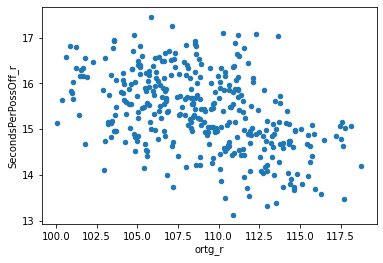

In [95]:
df.plot.scatter(x='ortg_r',y=ofspeed+'_r')

In [96]:

#print(df['drtg_r'].corr(df[dfspeed+'_r']))
print(df[dfspeed+'_p'].corr(df['drtg_p']))

-0.2569213583054551


<AxesSubplot:xlabel='speed_change', ylabel='drtg_change'>

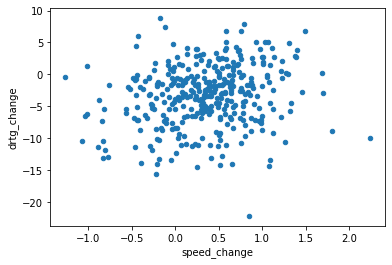

In [97]:
df.plot.scatter(x='speed_change',y='drtg_change')

In [98]:
reg_speed = rdf.groupby('year')['Pace'].mean()

pos_speed = pdf.groupby('year')['Pace'].mean()
pos_speed - reg_speed

year
2001   -1.395749
2002   -0.790494
2003   -0.907478
2004   -1.100321
2005   -1.261379
2006   -1.503085
2007   -2.021198
2008   -3.705623
2009   -3.778824
2010   -2.836865
2011   -4.078766
2012   -2.365164
2013   -2.012729
2014   -3.220409
2015    0.484665
2016   -2.872250
2017   -1.947268
2018   -1.200127
2019   -2.054487
2020   -1.979361
2021   -2.764696
2022   -2.833893
2023         NaN
Name: Pace, dtype: float64

In [99]:
def_reg = rdf.groupby('year')[dfspeed].mean()

def_pos = pdf.groupby('year')[dfspeed].mean()
def_pos - def_reg

year
2001    0.286580
2002    0.065401
2003    0.172254
2004    0.335795
2005    0.359005
2006    0.339758
2007    0.399820
2008    0.862110
2009    0.715776
2010    0.577107
2011    0.886442
2012    0.281582
2013    0.513589
2014    0.540480
2015   -0.024579
2016    0.516363
2017    0.326387
2018    0.233113
2019    0.258123
2020    0.282968
2021    0.428418
2022    0.483502
2023         NaN
Name: SecondsPerPossDef, dtype: float64

In [88]:
off_reg = rdf.groupby('year')[ofspeed].mean()

off_pos = pdf.groupby('year')[ofspeed].mean()
off_pos - def_reg

year
2001    0.250398
2002    0.211715
2003    0.147143
2004    0.118702
2005    0.122266
2006    0.290905
2007    0.308405
2008    0.370654
2009    0.633196
2010    0.395183
2011    0.538872
2012    0.520642
2013    0.247196
2014    0.508604
2015   -0.090366
2016    0.421382
2017    0.336858
2018    0.187308
2019    0.332709
2020    0.365232
2021    0.402909
2022    0.448852
2023         NaN
dtype: float64

In [59]:
rdf[rdf.year ==2023][['Name','drtg']].sort_values(by = 'drtg')
test = [x for x in rdf.columns if 'speed' in x.lower()]
test

[]

In [103]:
series = pd.read_csv('../playoffs/series_ratings.csv')

In [104]:
test = df[df.year==2022]
test[[ofspeed+'_p',ofspeed+'_r']]

,SecondsExcludingORebsPerPossOff_p,SecondsExcludingORebsPerPossOff_r
626,13.833876,13.467029
629,15.001757,14.377769
630,13.291064,13.435419
633,14.722288,14.517040
636,14.932773,14.514503
637,14.811966,14.212763
638,14.922801,14.388882
641,15.233393,14.293358
642,15.405430,14.916128
643,14.684492,14.070898


In [61]:
rdf.columns

Index(['SecondsPerPossOff', 'SecondsPerPossDef',
       'SecondsExcludingORebsPerPossOff', 'SecondsExcludingORebsPerPossDef',
       'ortg', 'drtg', 'Name', 'year'],
      dtype='object')